# Access watershed routing information

Ming Han and colleagues have recently published a [pan-Canadian river routing information geospatial database](https://zenodo.org/record/3667677#.YEag8-2YVH4). It describes river channels, lakes and reservoirs, watershed slopes and river slopes, enbankments, mean elevation, etc. This database is hosted on the PAVICS geoserver and a few utilities have been created to access it. This information can then be used to create Raven configuration files for sub-basins routing in distributed model configurations. 

This notebook demonstrates how to build a table of watershed properties from version 1 of this geospatial database. Version 2 should become available in April or May and this will be updated, so consider this notebook as a draft. 

In [1]:
import os
import tempfile
from pathlib import Path

import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sgeo

from ravenpy.utilities import geoserver
from ravenpy.utilities.testdata import get_local_testdata

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Get routing information for a given location 

Here we're fetching watershed information for the subbasin including [Amadjuak Lake](https://en.wikipedia.org/wiki/Amadjuak_Lake), located on Baffin Island's Great Plain of the Koukdjuak (Nunavut), using `geoserver.get_hydro_routing_location_wfs()`.

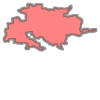

In [2]:
amadjuak = (-71.225, 65.05)

feature = geoserver.get_hydro_routing_location_wfs(
    coordinates=amadjuak * 2, lakes="1km", level=7
)

with open(tempfile.NamedTemporaryFile(suffix=".gml").name, "wb") as gml:
    gml.write(feature)
    
# GeoPandas cannot read a GML from Geoserver directly; Parse with fiona.
with fiona.open(gml.name) as src:
    feat = next(iter(src))
    geometry = sgeo.shape(feat["geometry"])
    subbasin_id = feat["properties"]["SubId"]

display(geometry)


In [3]:
gpd.GeoDataFrame.from_features([feat])

,geometry,gml_id,area,SubId,DowSubId,Rivlen,RivSlope,BasinSlope,BkfWidth,BkfDepth,...,LakeArea,Laketype,IsObs,MeanElev,FloodP_n,Q_Mean,Ch_n,INSIDE_X,INSIDE_Y,STATION_NU
0,"MULTIPOLYGON (((-72.04580 65.22920, -72.04580 ...",routing_1kmLakes_07.16393,9.110308e+09,29881.0,30001.0,132876.0,0.000069,0.012235,46.6959,1.14224,...,2994.94,1.0,-9999.99,144.388,0.048342,49.4539,0.008963,-71.318408,64.787276,None


## Fetching routing information for upstream watersheds

With the subbasin ID (`SubId`) for the feature, we can now find all upstream watersheds using `geoserver.hydro_routing_upstream_ids()`. 

This function requires information about up-down relationships between watersheds. We can get this info using `geoserver.get_hydro_routing_attributes_wfs()`. This function returns a URL to a JSON-encoded subset, and GeoPandas uses some magic to load it into a GeoDataFrame. Getting this info takes a while... 

In [4]:
# With a watershed ID to reduce the size of requests, this will be faster
region_url = geoserver.get_hydro_routing_attributes_wfs(
    attribute="SubId", value="*", lakes="1km", level=7
)
gdf = gpd.read_file(region_url)

gdf_upstream = geoserver.hydro_routing_upstream_ids(subbasin_id, gdf)
display(gdf_upstream)

,id,area,SubId,DowSubId,Rivlen,RivSlope,BasinSlope,BkfWidth,BkfDepth,IsLake,...,Laketype,IsObs,MeanElev,FloodP_n,Q_Mean,Ch_n,INSIDE_X,INSIDE_Y,STATION_NU,geometry
16389,routing_1kmLakes_07.16390,1.561850e+09,29878,29957,43618.900,0.001001,0.011948,28.2839,0.783040,-9999.99,...,-9999.99,-9999.99,270.853,0.049727,15.82250,0.033922,-69.639583,64.593750,,"MULTIPOLYGON (((-69.88330 64.42920, -69.88330 ..."
16390,routing_1kmLakes_07.16391,2.117180e+09,29879,29957,633.787,0.000100,0.026252,22.4685,0.649329,-9999.99,...,-9999.99,-9999.99,381.230,0.049898,10.83760,0.146774,-69.095873,64.523379,,"MULTIPOLYGON (((-69.87920 64.35830, -69.88750 ..."
16392,routing_1kmLakes_07.16393,9.110308e+09,29881,30001,132876.000,0.000069,0.012235,46.6959,1.142240,1.00,...,1.00,-9999.99,144.388,0.048342,49.45390,0.008963,-71.318408,64.787276,,"MULTIPOLYGON (((-72.04580 65.22920, -72.04580 ..."
16449,routing_1kmLakes_07.16450,6.153782e+06,29938,29955,833.501,0.001200,0.005017,12.7818,0.422461,1.00,...,1.00,-9999.99,166.853,0.050000,3.15153,0.053123,-70.526103,65.240196,,"MULTIPOLYGON (((-70.50420 65.26670, -70.50420 ..."
16450,routing_1kmLakes_07.16451,7.908222e+06,29939,30004,1328.880,0.002258,0.011083,11.7369,0.395272,1.00,...,1.00,-9999.99,350.943,0.050000,2.65731,0.039359,-69.783501,65.122103,,"MULTIPOLYGON (((-69.76250 65.10420, -69.78750 ..."
16451,routing_1kmLakes_07.16452,8.290501e+06,29940,30005,988.695,0.002023,0.006781,11.7369,0.395272,1.00,...,1.00,-9999.99,292.286,0.050000,2.65731,0.058264,-69.976854,65.061790,,"MULTIPOLYGON (((-69.95830 65.06250, -69.95830 ..."
16452,routing_1kmLakes_07.16453,3.656614e+08,29941,30006,2696.100,0.000742,0.009481,17.4253,0.537979,1.00,...,1.00,-9999.99,231.015,0.051667,5.85728,0.025679,-70.191934,65.097385,,"MULTIPOLYGON (((-70.21670 64.90420, -70.21670 ..."
16453,routing_1kmLakes_07.16454,4.038877e+06,29942,29956,929.087,0.000100,0.000925,22.3404,0.653033,1.00,...,1.00,-9999.99,151.500,0.050000,9.62755,0.031088,-70.270833,64.859375,,"MULTIPOLYGON (((-70.25830 64.86250, -70.25830 ..."
16454,routing_1kmLakes_07.16455,5.105304e+07,29943,30008,3474.390,0.002878,0.012721,14.1089,0.456297,1.00,...,1.00,-9999.99,352.823,0.050000,3.83989,0.047209,-69.350454,64.802016,,"MULTIPOLYGON (((-69.35420 64.73750, -69.37920 ..."
16455,routing_1kmLakes_07.16456,1.501280e+07,29944,29878,2990.080,0.002341,0.013047,18.3889,0.561046,1.00,...,1.00,-9999.99,258.896,0.061667,6.52299,0.046427,-69.719287,64.767958,,"MULTIPOLYGON (((-69.72080 64.80420, -69.72080 ..."


Number of features: 33


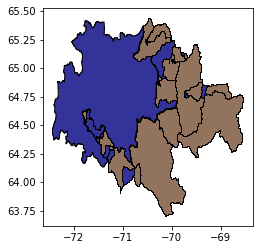

In [5]:
# Plotting all features upstream of the subbasin of interest, including Amadjuak Lake. 
# Lakes are in blue and land in brown. 
# Note that the contours show basins that include lakes, not the lakes themselves.

gdf_upstream.plot(column="IsLake", cmap="terrain_r", edgecolor="black", vmin=-14000)
print(f"Number of features: {len(gdf_upstream)}")